In [ ]:
!pip install datasets
from datasets import load_dataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from transformers import BertTokenizer, BertModel
from transformers import Trainer, TrainingArguments

import torch
from torch.utils.data import Dataset, DataLoader

from bs4 import BeautifulSoup
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = '/content/drive/My Drive/Colab Notebooks/LING 227: Final Project/amazon_review.csv'
reviews = pd.read_csv(data)
reviews = reviews[['reviewText', 'overall']]
reviews.dropna(inplace=True)

def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

reviews['cleaned_review'] = reviews['reviewText'].apply(text_cleaning)

Mounted at /content/drive


<ipython-input-3-e578ad288230>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    reviews['reviewText'].tolist(),
    reviews['overall'].tolist(),
    test_size=0.2,
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42
)

train_data = {"text": train_texts, "label": train_labels}
val_data = {"text": val_texts, "label": val_labels}
test_data = {"text": test_texts, "label": test_labels}

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

amazon = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})




DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2948
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 983
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 983
    })
})


In [ ]:
label_names = amazon["train"].features['label']
label_names


Value(dtype='float64', id=None)

In [ ]:

amazon.set_format(type="pandas")
train_df = amazon['train'][:]
valid_df = amazon['validation'][:]
test_df = amazon['test'][:]

train_df['label'] = train_df['label'] - 1  # Shift labels to 0-4 (if labels were from 1 to 5)
valid_df['label'] = valid_df['label'] - 1
test_df['label'] = test_df['label'] - 1
'''
train_df = train_df.groupby('label').apply(lambda x: x.sample(54)).reset_index(drop=True)
valid_df = valid_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)
test_df = test_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)'''

"\ntrain_df = train_df.groupby('label').apply(lambda x: x.sample(54)).reset_index(drop=True)\nvalid_df = valid_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)\ntest_df = test_df.groupby('label').apply(lambda x: x.sample(13)).reset_index(drop=True)"

In [ ]:
train_df['label'].value_counts()


,count
label,
4.0,2349
3.0,312
0.0,153
2.0,80
1.0,54


In [ ]:
print(test_df['label'].value_counts())

label
4.0    792
3.0    106
0.0     46
2.0     26
1.0     13
Name: count, dtype: int64


In [ ]:
train_df

,text,label
0,"We can't beat Class 10 flash memory speeds, at...",4.0
1,"SanDisk is always reliable, and I have always ...",4.0
2,Seems to work just fine. I have loaded it up a...,4.0
3,We use these for our Samsung Galaxy 4s phones ...,4.0
4,This MicroSDXC fits great in my Surface Pro ta...,4.0
...,...,...
2943,These cards never let you down. They are pric...,4.0
2944,Purchased this as a memory addition for the Su...,4.0
2945,I paid less than $60 shipped to my door. Had i...,4.0
2946,"I formatted the card, saved the data from phon...",4.0


In [ ]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([2948]), torch.Size([983]), torch.Size([983]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 20
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
from transformers import BertForSequenceClassification
N_labels = len(train_df.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
N_labels

5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer,
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))


Epoch:  1


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.929694493880143 
50/50 val loss: 0.7636443388462066 
Epoch:  2


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.7012947401082193 
50/50 val loss: 0.6579976031184196 
Epoch:  3


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.6102287178305356 
50/50 val loss: 0.6123045419156551 
Epoch:  4


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.5578533922498291 
50/50 val loss: 0.5849057725071907 
Epoch:  5


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.5253476905258926 
50/50 val loss: 0.5733922208845615 
Epoch:  6


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.4956438739758891 
50/50 val loss: 0.5615737847983837 
Epoch:  7


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.4691134975165934 
50/50 val loss: 0.5645208178460598 
Epoch:  8


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.45633104539199454 
50/50 val loss: 0.5629408244788646 
Epoch:  9


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.4377791156639924 
50/50 val loss: 0.571332551240921 
Epoch:  10


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.42186170615054464 
50/50 val loss: 0.5633473820239305 
Epoch:  11


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.4046726882256366 
50/50 val loss: 0.5744490113854408 
Epoch:  12


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.3855225207233751 
50/50 val loss: 0.5815745317935943 
Epoch:  13


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.3781294050953678 
50/50 val loss: 0.5811046341061592 
Epoch:  14


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.3620074204093701 
50/50 val loss: 0.5894769340008498 
Epoch:  15


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.34702327333994815 
50/50 val loss: 0.5949237290769815 
Epoch:  16


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.34030788625917724 
50/50 val loss: 0.5974618228524924 
Epoch:  17


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.3282089761986926 
50/50 val loss: 0.5987419945001602 
Epoch:  18


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.31949928105884307 
50/50 val loss: 0.6052723804861307 
Epoch:  19


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.307549509899439 
50/50 val loss: 0.6091795969754458 
Epoch:  20


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.29898821902335493 
50/50 val loss: 0.6145132409036159 
Epoch:  21


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.2976570016125569 
50/50 val loss: 0.6195540974289179 
Epoch:  22


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.2912972451917626 
50/50 val loss: 0.6228323972225189 
Epoch:  23


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.28634807308884086 
50/50 val loss: 0.6271371304243804 
Epoch:  24


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.2755546159538868 
50/50 val loss: 0.6296367789059878 
Epoch:  25


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.27251204392696554 
50/50 val loss: 0.6319820335507393 
Epoch:  26


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.26848306033659625 
50/50 val loss: 0.6337667037919164 
Epoch:  27


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.27302638733306445 
50/50 val loss: 0.6330622158944607 
Epoch:  28


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.2598716182936285 
50/50 val loss: 0.6357379572466015 
Epoch:  29


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.2602414872144928 
50/50 val loss: 0.6366687285900116 
Epoch:  30


Training:   0%|          | 0/148 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

148/148 train loss: 0.2689471730861712 
50/50 val loss: 0.6366029309853911 


In [ ]:
print(output.logits.shape)  # Ensure this is (batch_size, 5)


torch.Size([3, 5])


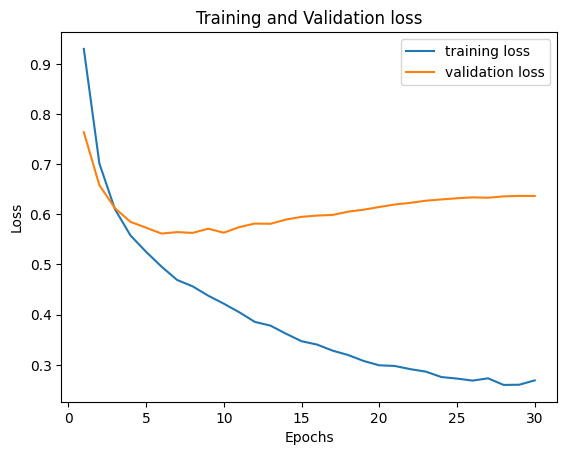

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
label_names = ["1 star", "2 star", "3 star", "4 star", "5 star"]
label_names

['1 star', '2 star', '3 star', '4 star', '5 star']

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(5, 5))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

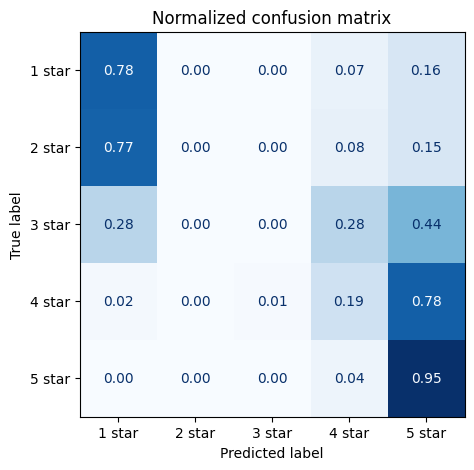

In [ ]:
plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)


In [ ]:
print("Unique classes in valid_pred:", np.unique(valid_pred))
print("Unique classes in valid_df['label']:", np.unique(valid_df['label']))
print("Provided label names:", label_names)
print("Length of label_names:", len(label_names))


Unique classes in valid_pred: [0 2 3 4]
Unique classes in valid_df['label']: [0. 1. 2. 3. 4.]
Provided label names: ['1 star', '2 star', '3 star', '4 star', '5 star']
Length of label_names: 5


In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report
              precision    recall  f1-score   support

      1 star       0.78      0.51      0.62        71
      2 star       0.00      0.00      0.00         0
      3 star       0.00      0.00      0.00         3
      4 star       0.13      0.24      0.17        59
      5 star       0.95      0.89      0.92       850

    accuracy                           0.82       983
   macro avg       0.37      0.33      0.34       983
weighted avg       0.89      0.82      0.85       983



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


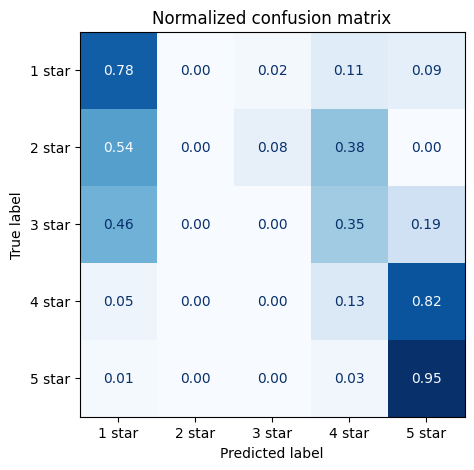

In [ ]:
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)


In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)


(179, 3)


,text,label,pred
0,Works as describe. If your going to use it in...,4.0,3
7,I bought this a little under a year ago to use...,2.0,0
9,I have a GoPro 3 camera with which the cards (...,3.0,4
17,"I had to return this and get another one, as t...",3.0,0
22,I'm finding more and more electronics are usin...,3.0,4
32,I purchased the Sandisk Ultra 32GB microSDHC f...,3.0,4
37,I bought this as a gift for a co worker he wen...,3.0,4
39,"With a USB 3.0 card reader, CrystalDiskMark sh...",1.0,3
44,"I bought this for my GoPro HD Hero 3 camera, a...",3.0,4
45,"It is good, and can work well in my Canon Powe...",4.0,3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/My Drive/Colab Notebooks/LING 227: Final Project/amazon_bert_model_30Epoch_16BS_2e-6.pth'

torch.save({
    'epoch': epoch_num,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': train_loss_per_epoch,
    'val_loss': val_loss_per_epoch,
}, model_save_path)
print(f"Model saved to {model_save_path}")

from google.colab import files

files.download(model_save_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/My Drive/Colab Notebooks/LING 227: Final Project/amazon_bert_model_30Epoch_16BS_2e-6.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>